In [134]:
import pandas as pd
import category_encoders as ce
import datetime as dt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


Load dataset

In [135]:
df = pd.read_csv('dataset.csv')

In [136]:
df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


Drop empty fields and country code because those are unnecessary

In [137]:
df = df.dropna()
df = df.drop('Country_code', axis=1)

Transform date to a single numeric value, in this instance i used days since first report

In [138]:
df['Date_reported'] = pd.to_datetime(df['Date_reported'])
base_date = pd.Timestamp('2020-01-01')
df['Days_since_base_date'] = (df['Date_reported'] - base_date).dt.days

Encoding country and region which is required for some models

In [139]:
encoder = ce.TargetEncoder(cols=['Country', 'WHO_region'])

df[['Country', 'WHO_region']] = encoder.fit_transform(df[['Country', 'WHO_region']], df['Cumulative_deaths'])

In [140]:
df.head()

,Date_reported,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Days_since_base_date
0,2020-01-03,4774.151288,9730.002947,0,0,0,0,2
1,2020-01-04,4774.151288,9730.002947,0,0,0,0,3
2,2020-01-05,4774.151288,9730.002947,0,0,0,0,4
3,2020-01-06,4774.151288,9730.002947,0,0,0,0,5
4,2020-01-07,4774.151288,9730.002947,0,0,0,0,6


The code below calculates the correlation between the 'Cumulative_deaths' variable and all other variables in the DataFrame. The corr() function computes the pairwise correlation of all columns in the DataFrame.

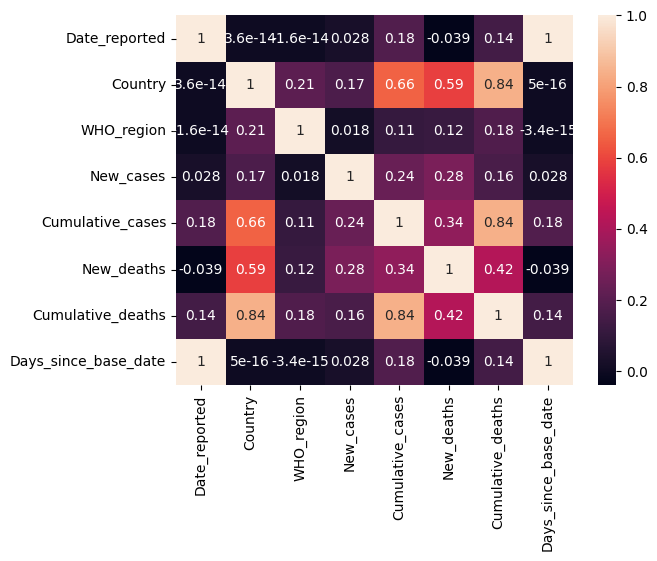

In [141]:
# Calculate the correlation matrix
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

This prepares dataset for the following methods of identifying predictive features

In [142]:

X = df.drop(['Cumulative_deaths','Date_reported'], axis=1)
y = df['Cumulative_deaths']

X.head()

,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Days_since_base_date
0,4774.151288,9730.002947,0,0,0,2
1,4774.151288,9730.002947,0,0,0,3
2,4774.151288,9730.002947,0,0,0,4
3,4774.151288,9730.002947,0,0,0,5
4,4774.151288,9730.002947,0,0,0,6



The code snippet provided below performs feature selection using Recursive Feature Elimination (RFE) with a LinearRegression model. It selects the top 2 features based on their importance for predicting the target variable (y).

The output of the code would be a bar plot showing the feature importances. The x-axis represents the rankings of the features, and the y-axis represents the feature names. The plot visualizes the importance of each feature based on their ranking. Features with lower rankings are considered more important.

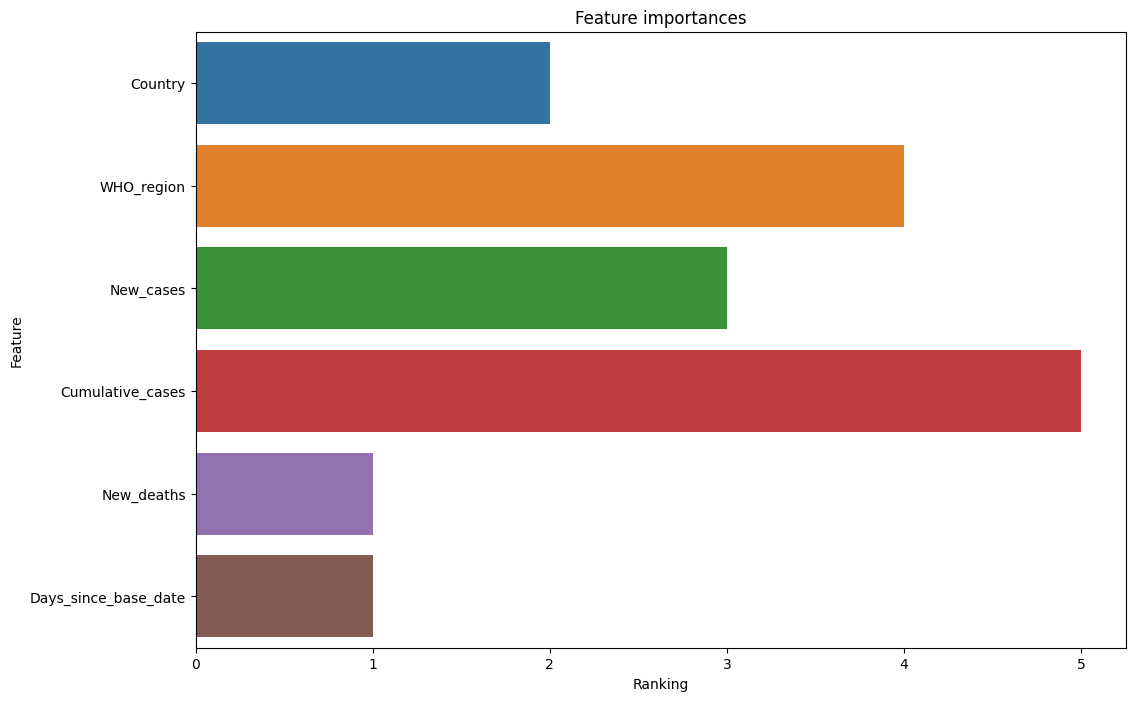

In [143]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=2)
fit = rfe.fit(X, y)

ranked_features = pd.DataFrame()
ranked_features['Feature'] = X.columns
ranked_features['Ranking'] = fit.ranking_

plt.figure(figsize=(12,8))
sns.barplot(data=ranked_features, x='Ranking', y='Feature')
plt.title('Feature importances')
plt.show()

The code snippet provided performs feature ranking using an ExtraTreesRegressor model. After fitting the model to the training data (X and y), it assigns importance scores to each feature. The importance scores reflect the relative significance of each feature in predicting the target variable (y).

The final output would be the ranked_features DataFrame or the plot, where the features are ranked in descending order of importance, with the most important feature listed first.

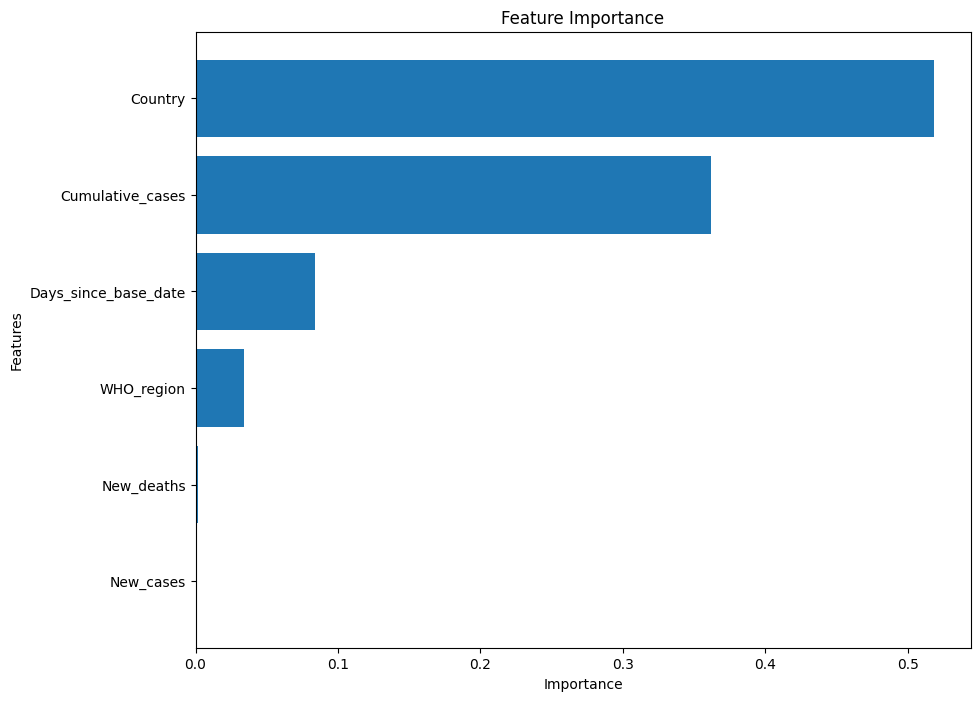

In [144]:
model = ExtraTreesRegressor()
model.fit(X, y)

ranked_features = pd.DataFrame()
ranked_features['Feature'] = X.columns
ranked_features['Ranking'] = model.feature_importances_
ranked_features = ranked_features.sort_values(by='Ranking', ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(ranked_features['Feature'], ranked_features['Ranking'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

Filter the data for the first year
Get the last date in the original dataset

In [145]:
df_first_year = df[df['Date_reported'].dt.year == 2020]
last_date = df['Days_since_base_date'].max()

Fit a randomforestregressor model to predict values, i chosen this because it can represent non-linear features

In [146]:


X = df_first_year[['Country', 'Cumulative_cases', 'Days_since_base_date']]
y = df_first_year['Cumulative_deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)



predictions = {}
for country in df_first_year['Country'].unique():
    predict_df = pd.DataFrame([[country, df_first_year[df_first_year['Country'] == country]['Cumulative_cases'].iloc[-1], last_date]], columns=['Country', 'Cumulative_cases', 'Days_since_base_date'])
    prediction = model.predict(predict_df)
    predictions[country] = prediction[0]

Mean Squared Error:  2104.621126232467
R^2 Score:  0.9999918509727048


Predictions now contains results of estimated death count

In [147]:
actual_deaths_dict = df[df['Days_since_base_date'] == last_date].set_index('Country')['Cumulative_deaths'].to_dict()


Match predictions to actual values

In [148]:
matched_predictions = {country: predictions[country] for country in actual_deaths_dict.keys() if country in predictions}
matched_actuals = {country: actual_deaths_dict[country] for country in actual_deaths_dict.keys() if country in matched_predictions}

predicted_deaths = np.array(list(matched_predictions.values()))
actual_deaths = np.array(list(matched_actuals.values()))

Report error rates

In [149]:
mae = mean_absolute_error(actual_deaths, predicted_deaths)
mse = mean_squared_error(actual_deaths, predicted_deaths)
r2 = r2_score(actual_deaths, predicted_deaths)

print("Mean Absolute Error (MAE): ", mae)
print("Mean Squared Error (MSE): ", mse)
print("R^2 Score: ", r2)

Mean Absolute Error (MAE):  21621.053114035087
Mean Squared Error (MSE):  5779688566.121738
R^2 Score:  0.47081262883654285


Below is a representation of truth versus predicted values to visualise results

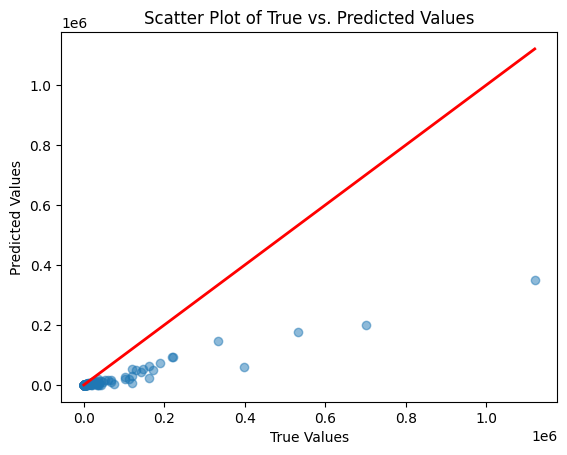

In [150]:
plt.scatter(actual_deaths, predicted_deaths, alpha=0.5)
plt.plot([actual_deaths.min(), actual_deaths.max()], [actual_deaths.min(), actual_deaths.max()], 'r', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.show()

Below, we make a bar chart representing error per country, as can be seen. Some countries have really low error rate

In [151]:
residuals = actual_deaths - predicted_deaths
error_dict = {country: error for country, error in zip(matched_actuals.keys(), residuals)}

# Sort the dictionary by error
error_dict = dict(sorted(error_dict.items(), key=lambda item: item[1]))


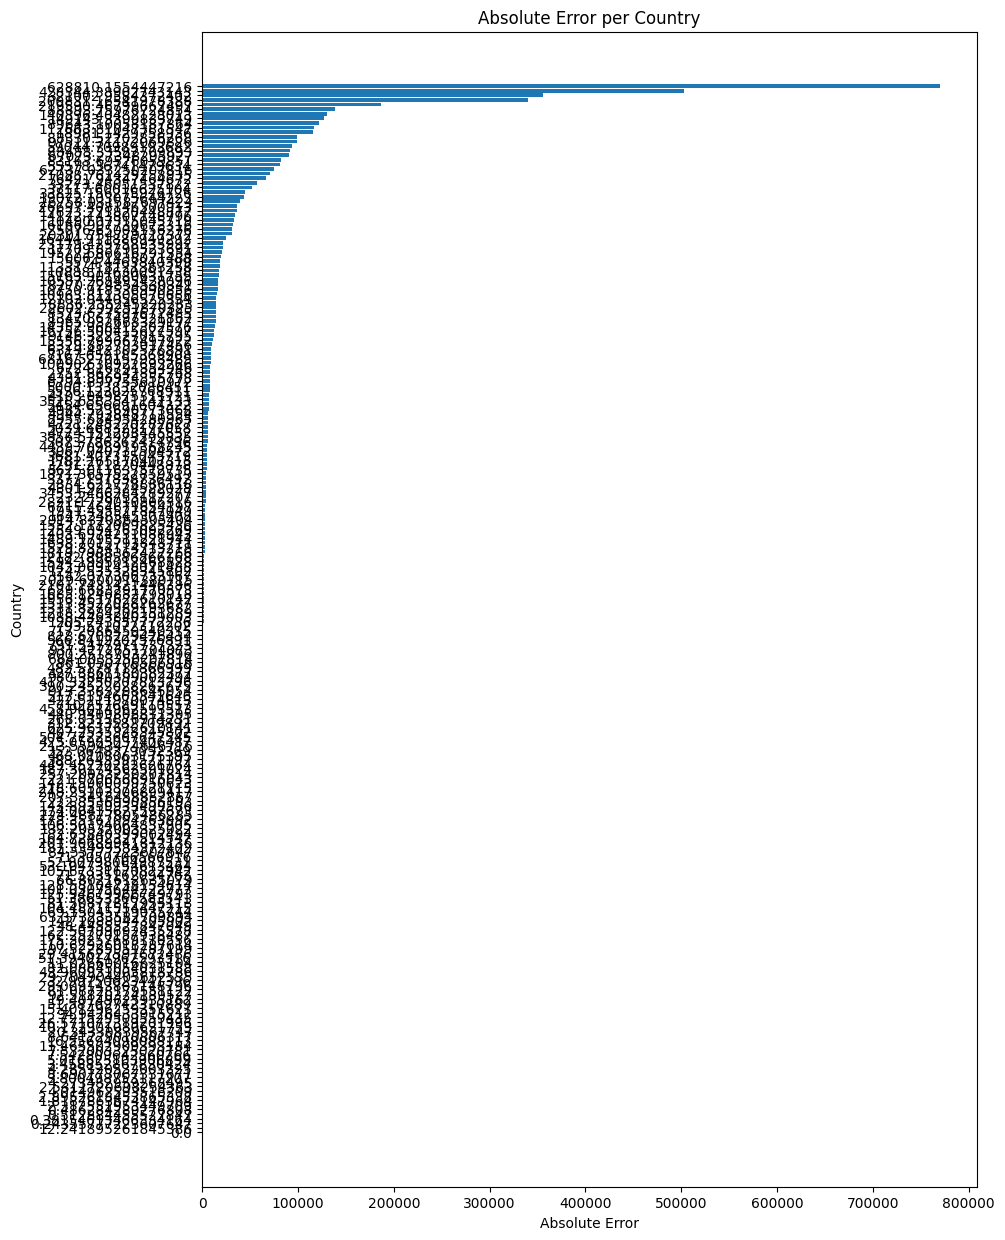

In [152]:

# Create a bar chart
plt.figure(figsize=(10, 15))
plt.barh(range(len(error_dict)), list(error_dict.values()), tick_label=list(error_dict.keys()))
plt.xlabel('Absolute Error')
plt.ylabel('Country')
plt.title('Absolute Error per Country')
plt.show()